C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures\Z: Found 100 text files
C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures\O: Found 100 text files
C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures\N: Found 100 text files
C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures\F: Found 100 text files
C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures\S: Found 100 text files

SPLITTING FILES BEFORE SEGMENTATION (Preventing Data Leakage)

NORMAL class file split:
  Train: 160 files
  Test:  40 files

INTERICTAL class file split:
  Train: 160 files
  Test:  40 files

ICTAL class file split:
  Train: 80 files
  Test:  20 files

PROCESSING TRAINING SET


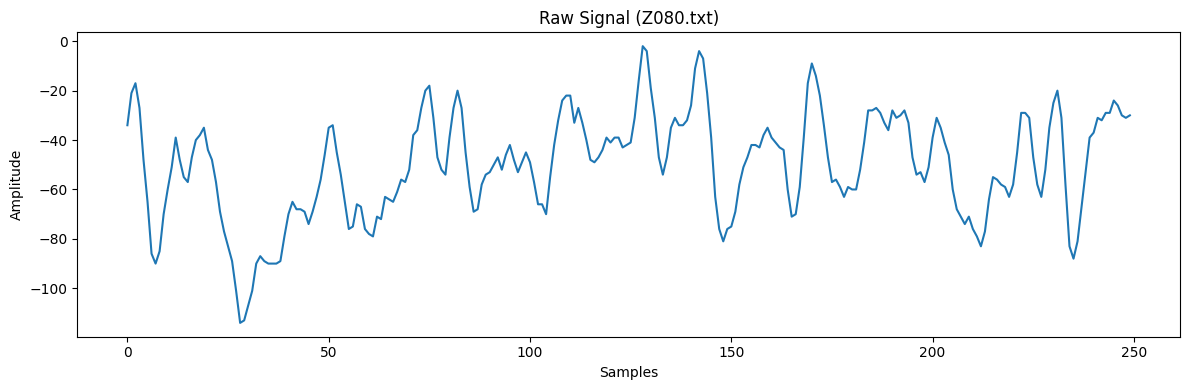

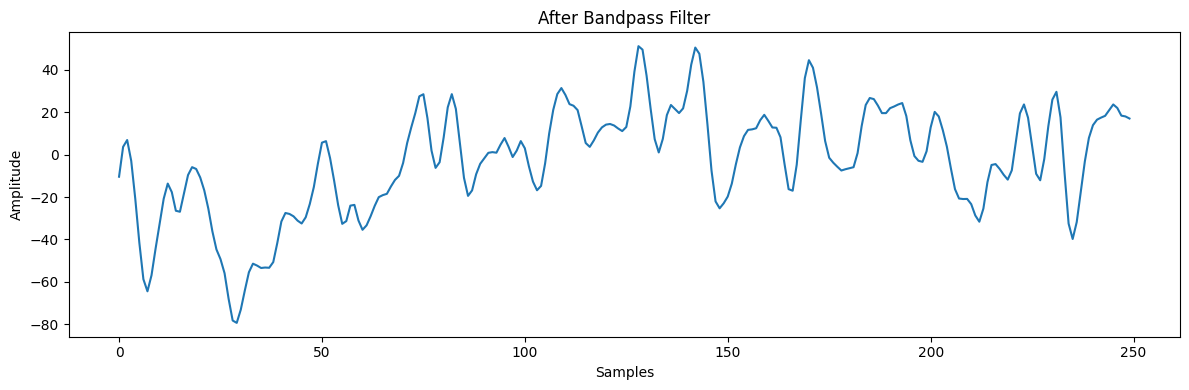

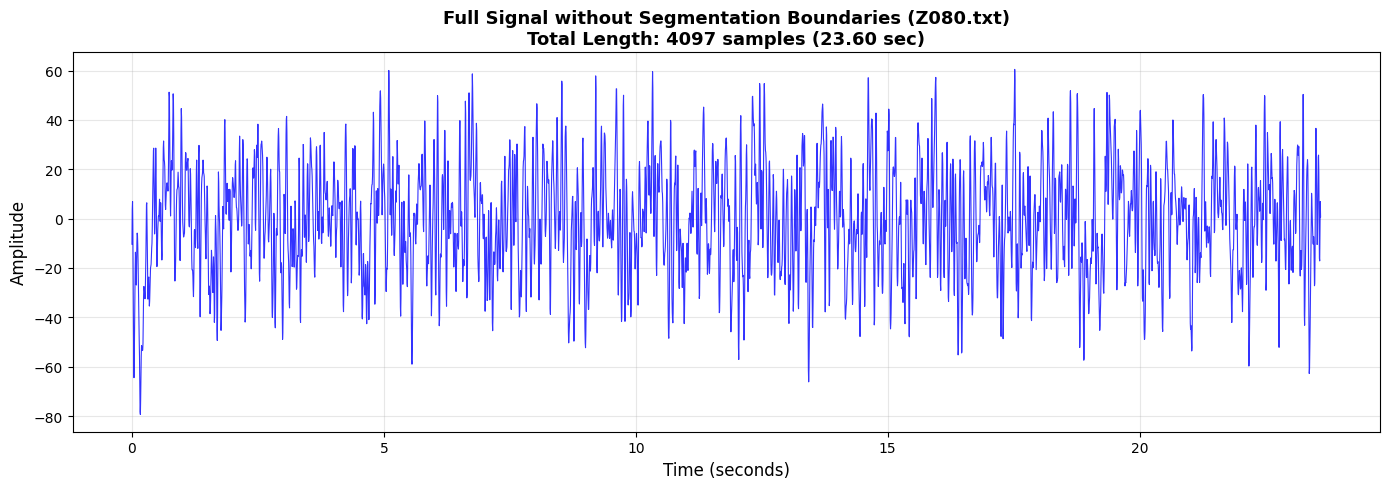

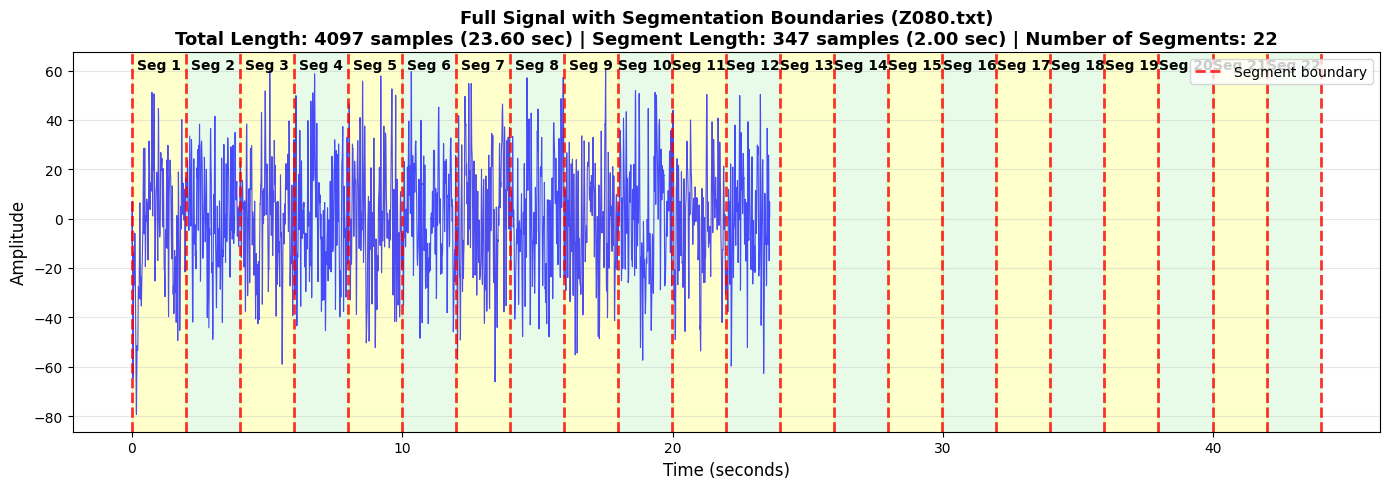

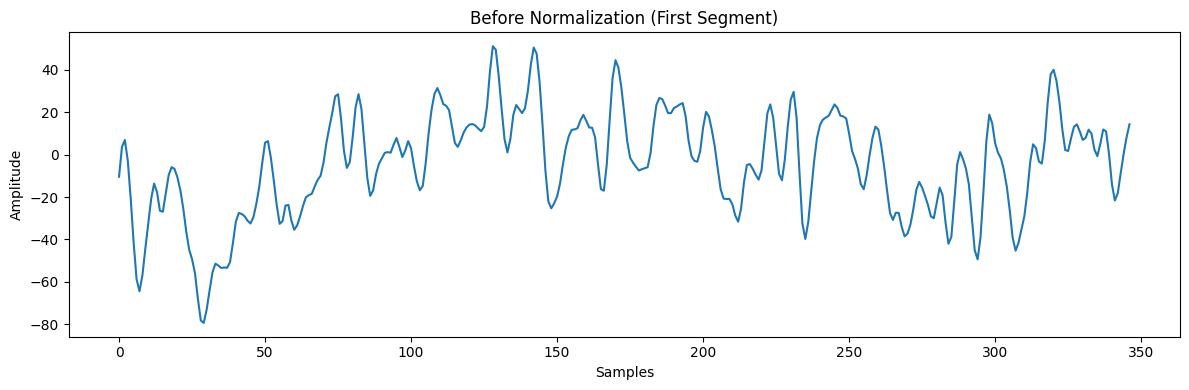

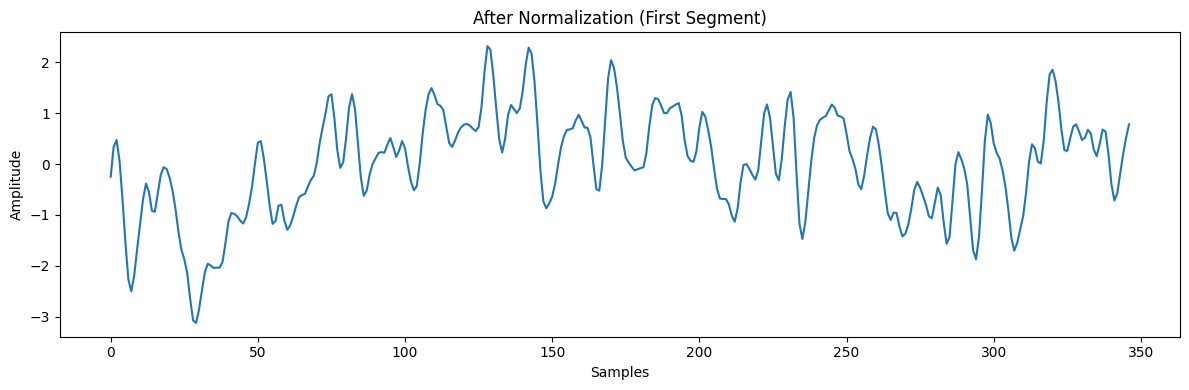

TRAIN - NORMAL: 3520 segments from 160 files
TRAIN - INTERICTAL: 3520 segments from 160 files
TRAIN - ICTAL: 1760 segments from 80 files

PROCESSING TEST SET
TEST - NORMAL: 880 segments from 40 files
TEST - INTERICTAL: 880 segments from 40 files
TEST - ICTAL: 440 segments from 20 files

✅ Saved training data: (8800, 347)
✅ Saved test data: (2200, 347)
✅ Saved combined data: (11000, 347) (for reference only)

VERIFICATION: No Data Leakage
Total files per class:
  NORMAL: 200 files (Train: 160, Test: 40)
  INTERICTAL: 200 files (Train: 160, Test: 40)
  ICTAL: 100 files (Train: 80, Test: 20)

✅ Files are properly separated BEFORE segmentation - No data leakage!

PREPROCESSING COMPLETE!
Training set: (8800, 347)
Test set:     (2200, 347)

Class distribution in training: (array(['ICTAL', 'INTERICTAL', 'NORMAL'], dtype='<U10'), array([1760, 3520, 3520]))
Class distribution in test:     (array(['ICTAL', 'INTERICTAL', 'NORMAL'], dtype='<U10'), array([440, 880, 880]))


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split

# Bandpass Filter
def bandpass_filter(data, lowcut=0.5, highcut=40, fs=173.61, order=5):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Preprocessing Function
def preprocess_signal(signal, fs=173.61, segment_length=None):
    # Bandpass Filter
    filtered = bandpass_filter(signal, 0.5, 50, fs)

    # Segmentation WITH OVERLAP
    if segment_length is None:
        segment_length = int(2 * fs)  # 2-second segments
    
    step_size = int(segment_length * (1 - 0.5))  # 50% overlap
    
    segments = []
    for start in range(0, len(filtered) - segment_length + 1, step_size):
        end = start + segment_length
        segments.append(filtered[start:end])
    
    segments = np.array(segments)

    # ✅ Z-score normalization (per segment)
    normed_segments = np.zeros_like(segments)
    for i in range(segments.shape[0]):
        mean = segments[i].mean()
        std = segments[i].std()
        if std > 0:  # Avoid division by zero
            normed_segments[i] = (segments[i] - mean) / std
        else:
            normed_segments[i] = segments[i] - mean  # Just center if std=0

    return normed_segments, filtered, segments


def plot_segmentation_detailed(filtered, segments, fs=173.61, segment_length=None, filename=""):
    if segment_length is None:
        segment_length = int(5 * fs)
    
    num_segments = len(segments)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # Plot the full filtered signal
    time = np.arange(len(filtered)) / fs
    ax.plot(time, filtered, 'b-', linewidth=0.8, alpha=0.7)
    
    # Add vertical lines to show segment boundaries
    for i in range(num_segments + 1):
        segment_time = i * segment_length / fs
        ax.axvline(x=segment_time, color='red', linestyle='--', 
                   linewidth=2, alpha=0.8, label='Segment boundary' if i == 0 else '')
    
    # Shade different segments with alternating colors
    for i in range(num_segments):
        start_time = i * segment_length / fs
        end_time = (i + 1) * segment_length / fs
        color = 'yellow' if i % 2 == 0 else 'lightgreen'
        ax.axvspan(start_time, end_time, alpha=0.2, color=color)
        # Add segment labels
        mid_time = (start_time + end_time) / 2
        ax.text(mid_time, ax.get_ylim()[1] * 0.9, f'Seg {i+1}', 
                ha='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    
    title = f'Full Signal with Segmentation Boundaries'
    if filename:
        title += f' ({filename})'
    title += f'\nTotal Length: {len(filtered)} samples ({len(filtered)/fs:.2f} sec) | '
    title += f'Segment Length: {segment_length} samples ({segment_length/fs:.2f} sec) | '
    title += f'Number of Segments: {num_segments}'
    
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# ==================== FIXED: Load & Preprocess Dataset ====================
def load_and_preprocess_bonn(root_dir, save_dir, test_size=0.2, random_state=42, plot_example=True):
    """
    Fixed version that splits raw files BEFORE segmentation to prevent data leakage
    
    Args:
        root_dir: Root directory containing Z, O, N, F, S folders
        save_dir: Directory to save preprocessed data
        test_size: Proportion of files for test set (default: 20%)
        random_state: Random seed for reproducibility
        plot_example: Whether to plot preprocessing steps
    """
    
    # Map folders to classes
    classes = {
        "Z": "NORMAL",
        "O": "NORMAL",
        "N": "INTERICTAL",
        "F": "INTERICTAL",
        "S": "ICTAL"
    }

    # ==================== STEP 1: Collect all file paths ====================
    files_by_class = {}
    
    for folder, label in classes.items():
        folder_path = os.path.join(root_dir, folder)
        files = glob.glob(os.path.join(folder_path, "**", "*.txt"), recursive=True)
        
        if label not in files_by_class:
            files_by_class[label] = []
        files_by_class[label].extend(files)
        
        print(f"{folder_path}: Found {len(files)} text files")

    # ==================== STEP 2: Split files (NOT segments!) ====================
    train_files = {}
    test_files = {}
    
    print("\n" + "="*70)
    print("SPLITTING FILES BEFORE SEGMENTATION (Preventing Data Leakage)")
    print("="*70)
    
    for label, files in files_by_class.items():
        # Split files for each class
        train_f, test_f = train_test_split(
            files, 
            test_size=test_size, 
            random_state=random_state
        )
        
        train_files[label] = train_f
        test_files[label] = test_f
        
        print(f"\n{label} class file split:")
        print(f"  Train: {len(train_f)} files")
        print(f"  Test:  {len(test_f)} files")

    # ==================== STEP 3: Process train and test separately ====================
    def process_files(file_dict, split_name, plot=False):
        all_segments = []
        all_labels = []
        plotted = False
        
        for label, files in file_dict.items():
            class_segments = []
            
            for file_path in files:
                try:
                    data = np.loadtxt(file_path)
                    normed_segments, filtered, segments = preprocess_signal(data)
                    
                    # Plot one example (only for training set and only once)
                    if plot and not plotted and split_name == "TRAIN":
                        # 1. Raw Signal
                        plt.figure(figsize=(12, 4))
                        plt.plot(data[:250])
                        plt.title(f"Raw Signal ({os.path.basename(file_path)})")
                        plt.xlabel("Samples")
                        plt.ylabel("Amplitude")
                        plt.tight_layout()
                        plt.show()

                        # 2. After Bandpass Filter
                        plt.figure(figsize=(12, 4))
                        plt.plot(filtered[:250])
                        plt.title("After Bandpass Filter")
                        plt.xlabel("Samples")
                        plt.ylabel("Amplitude")
                        plt.tight_layout()
                        plt.show()

                        # 3. Full Filtered Signal BEFORE Segmentation
                        plt.figure(figsize=(14, 5))
                        time_full = np.arange(len(filtered)) / 173.61
                        plt.plot(time_full, filtered, 'b-', linewidth=0.8, alpha=0.8)
                        plt.xlabel('Time (seconds)', fontsize=12)
                        plt.ylabel('Amplitude', fontsize=12)
                        plt.title(f'Full Signal without Segmentation Boundaries ({os.path.basename(file_path)})\n' +
                                 f'Total Length: {len(filtered)} samples ({len(filtered)/173.61:.2f} sec)',
                                 fontsize=13, fontweight='bold')
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()
                        plt.show()

                        # 4. Detailed Segmentation Visualization
                        plot_segmentation_detailed(filtered, segments, 
                                                 fs=173.61, 
                                                 segment_length=int(2*173.61),
                                                 filename=os.path.basename(file_path))

                        # 5. Before Normalization
                        plt.figure(figsize=(12, 4))
                        plt.plot(segments[0])
                        plt.title("Before Normalization (First Segment)")
                        plt.xlabel("Samples")
                        plt.ylabel("Amplitude")
                        plt.tight_layout()
                        plt.show()
                        
                        # 6. After Normalization
                        plt.figure(figsize=(12, 4))
                        plt.plot(normed_segments[0])
                        plt.title("After Normalization (First Segment)")
                        plt.xlabel("Samples")
                        plt.ylabel("Amplitude")
                        plt.tight_layout()
                        plt.show()
                        
                        plotted = True
                    
                    class_segments.append(normed_segments)
                    
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
            
            if class_segments:
                class_segments = np.vstack(class_segments)
                labels = np.full(len(class_segments), label)
                all_segments.append(class_segments)
                all_labels.append(labels)
                
                print(f"{split_name} - {label}: {class_segments.shape[0]} segments from {len(files)} files")
        
        if all_segments:
            X = np.vstack(all_segments)
            y = np.concatenate(all_labels)
            return X, y
        return None, None

    # Process training and test sets separately
    print("\n" + "="*70)
    print("PROCESSING TRAINING SET")
    print("="*70)
    X_train, y_train = process_files(train_files, "TRAIN", plot=plot_example)
    
    print("\n" + "="*70)
    print("PROCESSING TEST SET")
    print("="*70)
    X_test, y_test = process_files(test_files, "TEST", plot=False)

    # ==================== STEP 4: Save the data ====================
    os.makedirs(save_dir, exist_ok=True)
    
    if X_train is not None:
        np.save(os.path.join(save_dir, "TRAIN_X.npy"), X_train)
        np.save(os.path.join(save_dir, "TRAIN_y.npy"), y_train)
        np.savetxt(os.path.join(save_dir, "TRAIN_X.txt"), X_train, fmt="%.6f")
        np.savetxt(os.path.join(save_dir, "TRAIN_y.txt"), y_train, fmt="%s")
        print(f"\n✅ Saved training data: {X_train.shape}")
    
    if X_test is not None:
        np.save(os.path.join(save_dir, "TEST_X.npy"), X_test)
        np.save(os.path.join(save_dir, "TEST_y.npy"), y_test)
        np.savetxt(os.path.join(save_dir, "TEST_X.txt"), X_test, fmt="%.6f")
        np.savetxt(os.path.join(save_dir, "TEST_y.txt"), y_test, fmt="%s")
        print(f"✅ Saved test data: {X_test.shape}")
    
    # Also save combined (for backward compatibility, but use split versions for training!)
    if X_train is not None and X_test is not None:
        X_all = np.vstack([X_train, X_test])
        y_all = np.concatenate([y_train, y_test])
        
        np.save(os.path.join(save_dir, "ALL_X.npy"), X_all)
        np.save(os.path.join(save_dir, "ALL_y.npy"), y_all)
        np.savetxt(os.path.join(save_dir, "ALL_X.txt"), X_all, fmt="%.6f")
        np.savetxt(os.path.join(save_dir, "ALL_y.txt"), y_all, fmt="%s")
        print(f"✅ Saved combined data: {X_all.shape} (for reference only)")

    # ==================== VERIFICATION ====================
    print("\n" + "="*70)
    print("VERIFICATION: No Data Leakage")
    print("="*70)
    print(f"Total files per class:")
    for label in files_by_class.keys():
        total = len(train_files[label]) + len(test_files[label])
        print(f"  {label}: {total} files (Train: {len(train_files[label])}, Test: {len(test_files[label])})")
    
    print("\n✅ Files are properly separated BEFORE segmentation - No data leakage!")

    return X_train, y_train, X_test, y_test


# Main
if __name__ == "__main__":
    root = r"C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures"
    save_dir = os.path.join(root, "preprocessed")

    X_train, y_train, X_test, y_test = load_and_preprocess_bonn(
        root, save_dir, test_size=0.2, random_state=42, plot_example=True
    )
    
    print("\n" + "="*70)
    print("PREPROCESSING COMPLETE!")
    print("="*70)
    print(f"Training set: {X_train.shape}")
    print(f"Test set:     {X_test.shape}")
    print(f"\nClass distribution in training: {np.unique(y_train, return_counts=True)}")
    print(f"Class distribution in test:     {np.unique(y_test, return_counts=True)}")